In [ ]:
# 2 Лабораторная работа

# Цель - познакомиться с методом кластеризации K-mean с помощью пакета sklearn. 

# Для выполнения задания используется набор данных из предыдущей лр.
# Что нужно сделать:
# 1. К текущему датасету необходимо добавить новый аттрибут, например, если есть дата рождения, 
# то посчитать возраст или определить популярность фильма по количеству просмотров и т.п.
# 2. "Причесать" датасет: удалить выбросы и дубли, обработать пропущенные значения, найти кривые данные и т.п.
# 3. Построить графики зависимости одной переменной от другой (plt.scatter), описать какие кластеры (группы) 
# вы видите. Построить несколько разных графиков, найти ярковыраженные группы.
# 4. Изучить перечисленные ноутбуки, по примеру, попробовать применить метод KMeans к вашему датасету 
# (https://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html)
# https://www.kaggle.com/kushal1996/customer-segmentation-k-means-analysis
# https://www.kaggle.com/karthickaravindan/k-means-clustering-project
# https://www.kaggle.com/hellbuoy/online-retail-k-means-hierarchical-clustering
# https://www.kaggle.com/sirpunch/k-means-clustering
# Если ваш датасет не подходит для задачи, его можно поменять. 

# 5. Написать выводы
# Если не установлен sklearn - https://scikit-learn.org/stable/install.html

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

df = pd.read_csv("../data/Sleep_health_and_lifestyle_dataset.csv")

In [2]:
df[['Systolic', 'Diastolic']] = df['Blood Pressure'].str.split('/', expand=True).astype(int)
df = df.fillna('None')

In [3]:
numeric_cols = [
    'Age',
    'Sleep Duration',
    'Quality of Sleep',
    'Physical Activity Level',
    'Stress Level',
    'Heart Rate',
    'Daily Steps',
    'Systolic',
    'Diastolic'
]

categorical_cols = [
    'Gender',
    'Occupation',
    'BMI Category',
    'Sleep Disorder'
]

In [4]:
# 2.1. К текущему датасету необходимо добавить новый аттрибут, например, если есть дата рождения, 
# то посчитать возраст или определить популярность фильма по количеству просмотров и т.п.

# Новый признак: чем выше — тем хуже баланс между стрессом и сном
df['Sleep_Stress_Index'] = df['Stress Level'] / df['Quality of Sleep']

In [5]:
# 2.2. "Причесать" датасет: удалить выбросы и дубли, обработать пропущенные значения, найти кривые данные и т.п.

def remove_outliers_iqr(df, col):
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1
    lower = Q1 - 1.5 * IQR
    upper = Q3 + 1.5 * IQR
    return df[(df[col] >= lower) & (df[col] <= upper)]

# Применим последовательно
df_clean = df.copy()
for col in numeric_cols:
    df_clean = remove_outliers_iqr(df_clean, col)

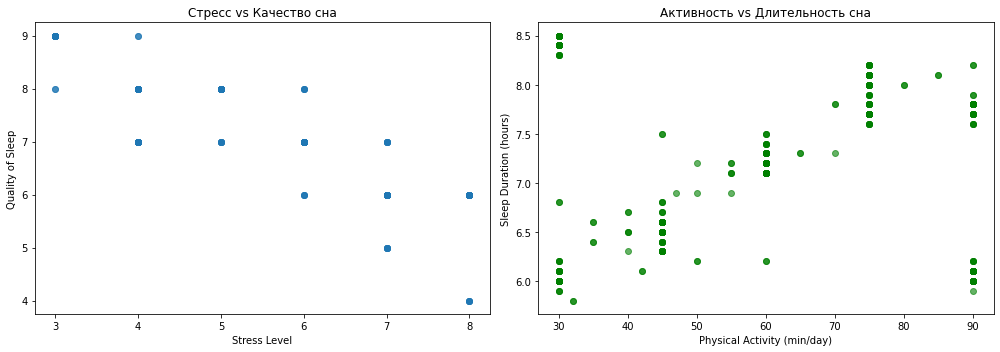

In [6]:
# 2.3. Построить графики зависимости одной переменной от другой (plt.scatter), описать какие кластеры (группы) 
# вы видите. Построить несколько разных графиков, найти ярковыраженные группы.

plt.figure(figsize=(14, 5))

# График 1: Стресс vs Качество сна
plt.subplot(1, 2, 1)
plt.scatter(df['Stress Level'], df['Quality of Sleep'], alpha=0.6)
plt.xlabel('Stress Level')
plt.ylabel('Quality of Sleep')
plt.title('Стресс vs Качество сна')

# График 2: Физическая активность vs Продолжительность сна
plt.subplot(1, 2, 2)
plt.scatter(df['Physical Activity Level'], df['Sleep Duration'], alpha=0.6, color='green')
plt.xlabel('Physical Activity (min/day)')
plt.ylabel('Sleep Duration (hours)')
plt.title('Активность vs Длительность сна')

plt.tight_layout()
plt.show()

In [7]:
# 2.4. Изучить перечисленные ноутбуки, по примеру, попробовать применить метод KMeans к вашему датасету 
# (https://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html)
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

# Выберем признаки для кластеризации (без ID и категориальных)
features = [
    'Age',
    'Sleep Duration',
    'Quality of Sleep',
    'Physical Activity Level',
    'Stress Level',
    'Heart Rate',
    'Daily Steps',
    'Systolic',
    'Diastolic',
    'Sleep_Stress_Index'
]

X = df[features]

# Стандартизация
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

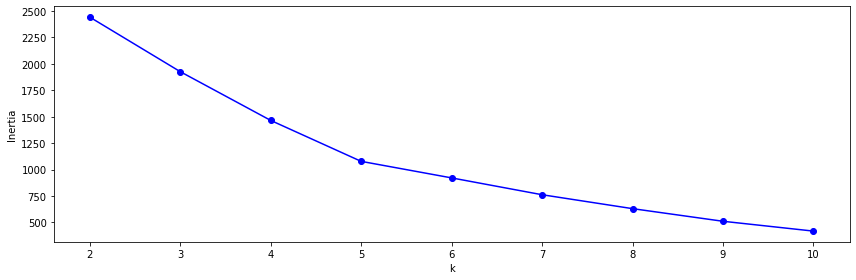

In [8]:
from sklearn.metrics import silhouette_score

inertias = []
silhouettes = []
K_range = range(2, 11)

for k in K_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init="auto")
    kmeans.fit(X_scaled)
    inertias.append(kmeans.inertia_)
    silhouettes.append(silhouette_score(X_scaled, kmeans.labels_))

# График инерции (локоть)
plt.figure(figsize=(12, 4))

plt.plot(K_range, inertias, 'bo-')
plt.xlabel('k')
plt.ylabel('Inertia')


plt.tight_layout()
plt.show()

In [9]:
k_opt = 5
kmeans = KMeans(n_clusters=k_opt, random_state=42, n_init="auto")
df['Cluster'] = kmeans.fit_predict(X_scaled)

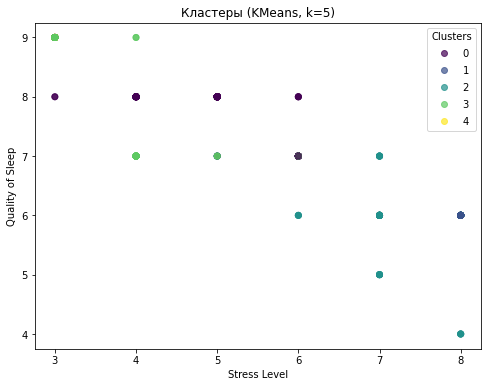

In [10]:
plt.figure(figsize=(8, 6))
scatter = plt.scatter(
    df['Stress Level'],
    df['Quality of Sleep'],
    c=df['Cluster'],
    cmap='viridis',
    alpha=0.7
)
plt.xlabel('Stress Level')
plt.ylabel('Quality of Sleep')
plt.title('Кластеры (KMeans, k=5)')
plt.legend(*scatter.legend_elements(), title="Clusters")
plt.show()

In [12]:
cluster_summary = df.groupby('Cluster')[features].mean()
print(cluster_summary)

               Age  Sleep Duration  Quality of Sleep  Physical Activity Level  \
Cluster                                                                         
0        37.268456        7.484564          7.785235                70.469799   
1        49.750000        6.065625          6.000000                90.000000   
2        37.484536        6.314433          5.948454                39.484536   
3        51.671875        7.437500          8.093750                61.875000   
4        52.781250        8.425000          9.000000                30.000000   

         Stress Level  Heart Rate   Daily Steps    Systolic  Diastolic  \
Cluster                                                                  
0            4.892617   68.966443   7569.798658  123.033557  80.731544   
1            8.000000   75.000000  10000.000000  140.000000  95.000000   
2            7.257732   73.618557   5548.453608  128.247423  83.494845   
3            3.578125   67.890625   6303.125000  137.921875  9